In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
df = pd.read_csv('E:/HDD Documents/HDD Documents/School/WGU/medical/medical_time_series .csv')

In [ ]:
df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [ ]:
#Check missing data
df.isnull().any()

Day        False
Revenue    False
dtype: bool

In [ ]:
#Convert the Day values to match deates in 2015
def convert_to_date(x):
    return datetime.date(2015,1,1) + datetime.timedelta(days = x - 1)
df['Date'] = df['Day'].apply(convert_to_date)
df

,Day,Revenue,Date
0,1,0.000000,2015-01-01
1,2,-0.292356,2015-01-02
2,3,-0.327772,2015-01-03
3,4,-0.339987,2015-01-04
4,5,-0.124888,2015-01-05
...,...,...,...
726,727,15.722056,2016-12-27
727,728,15.865822,2016-12-28
728,729,15.708988,2016-12-29
729,730,15.822867,2016-12-30


In [ ]:
df.set_index('Date', drop = True, inplace = True)
df

,Day,Revenue
Date,,
2015-01-01,1,0.000000
2015-01-02,2,-0.292356
2015-01-03,3,-0.327772
2015-01-04,4,-0.339987
2015-01-05,5,-0.124888
...,...,...
2016-12-27,727,15.722056
2016-12-28,728,15.865822
2016-12-29,729,15.708988


In [ ]:
#Drop unnecessary column
df2 = df[['Revenue']]
df2

,Revenue
Date,
2015-01-01,0.000000
2015-01-02,-0.292356
2015-01-03,-0.327772
2015-01-04,-0.339987
2015-01-05,-0.124888
...,...
2016-12-27,15.722056
2016-12-28,15.865822
2016-12-29,15.708988


In [ ]:
#Drop the first row to get rid of 0 Revenue value
df2 = df2[df2['Revenue'] != 0]
df2

,Revenue
Date,
2015-01-02,-0.292356
2015-01-03,-0.327772
2015-01-04,-0.339987
2015-01-05,-0.124888
2015-01-06,-0.491590
...,...
2016-12-27,15.722056
2016-12-28,15.865822
2016-12-29,15.708988


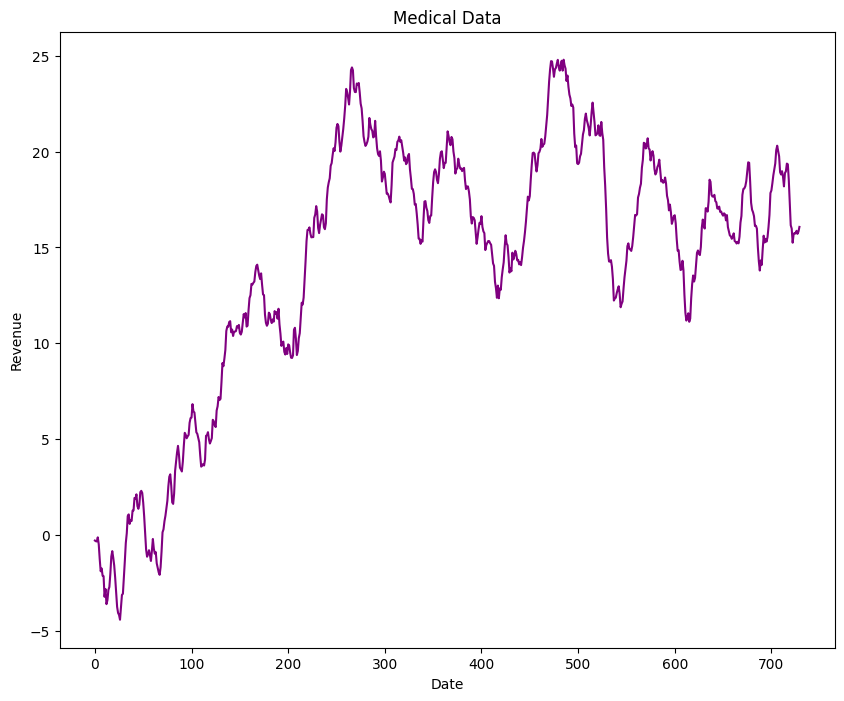

In [ ]:
index = pd.Series(range(df2.shape[0]))
fig, ax = plt.subplots(figsize = (10,8))

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Medical Data')
plt.plot(index, df2.Revenue, color = 'purple')
plt.show()

In [ ]:
#Use ADF to assess whether dataset is stationary or non-stationary 
df_test = ts.adfuller(df2['Revenue'], autolag = 'AIC')
df_op = pd.Series(df_test[0:4], index = ['ADF Statistic', 'p-Value', 'Lags', 'Observations'])
for key, value in df_test[4].items():
    df_op['Critical Value (%s)'%key] = value
df_op

ADF Statistic            -2.210771
p-Value                   0.202360
Lags                      1.000000
Observations            728.000000
Critical Value (1%)      -3.439364
Critical Value (5%)      -2.865518
Critical Value (10%)     -2.568888
dtype: float64

In [ ]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2015-01-02 to 2016-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  730 non-null    float64
dtypes: float64(1)
memory usage: 11.4+ KB
None


In [ ]:
df2.head()

,Revenue
Date,
2015-01-02,-0.292356
2015-01-03,-0.327772
2015-01-04,-0.339987
2015-01-05,-0.124888
2015-01-06,-0.491590


In [ ]:
#Transform dataset to stationary by using differencing (subtracting each point from the previous value).
df_stationary = df2.diff(periods = 1, axis = 0).dropna()
print(df_stationary.info())
print(df_stationary.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 2015-01-03 to 2016-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  729 non-null    float64
dtypes: float64(1)
memory usage: 11.4+ KB
None
(729, 1)


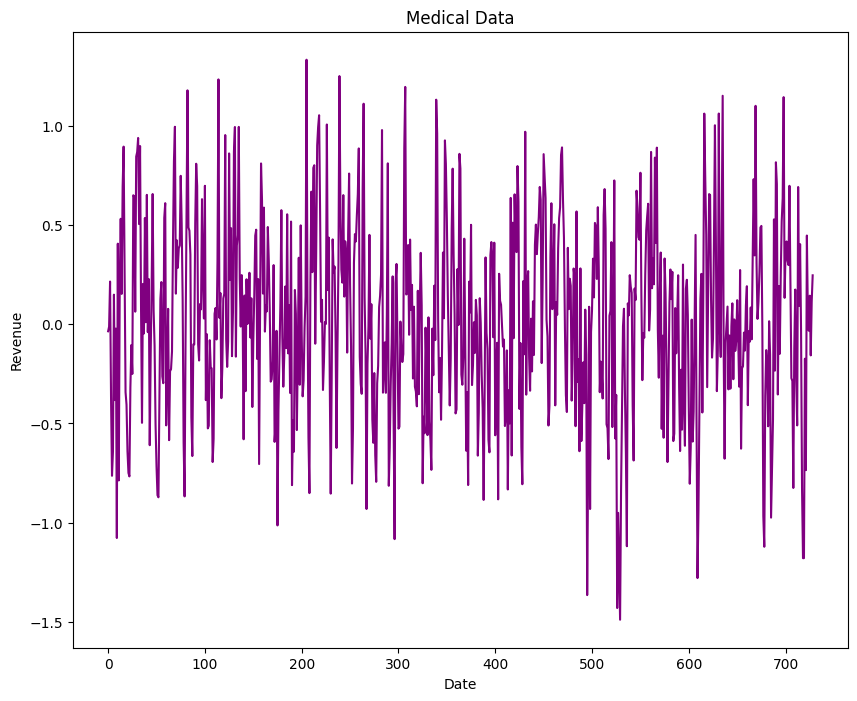

In [ ]:
index2 = pd.Series(range(df_stationary.shape[0]))
fig, ax = plt.subplots(figsize = (10,8))

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Medical Data')
plt.plot(index2, df_stationary.Revenue, color = 'purple')
plt.show()

In [ ]:
#Use ADF to reassess whether updated dataset is stationary or non-stationary 
df_test2 = ts.adfuller(df_stationary['Revenue'], autolag = 'AIC')
df_op2 = pd.Series(df_test2[0:4], index = ['ADF Statistic', 'p-Value', 'Lags', 'Observations'])
for key, value in df_test2[4].items():
    df_op2['Critical Value (%s)'%key] = value
df_op2

ADF Statistic          -1.735420e+01
p-Value                 5.249586e-30
Lags                    0.000000e+00
Observations            7.280000e+02
Critical Value (1%)    -3.439364e+00
Critical Value (5%)    -2.865518e+00
Critical Value (10%)   -2.568888e+00
dtype: float64

In [ ]:
#Create Training and Test, keeping the recommended 4:1 ratio
test_size = int(.20 * df_stationary.shape[0])
train, test = train_test_split(df_stationary, test_size = test_size, shuffle = False, random_state = 22)

In [ ]:
acf = acf((train['Revenue'].values))
acf_df = pd.DataFrame([acf]).T
acf_df.columns = ['ACF']

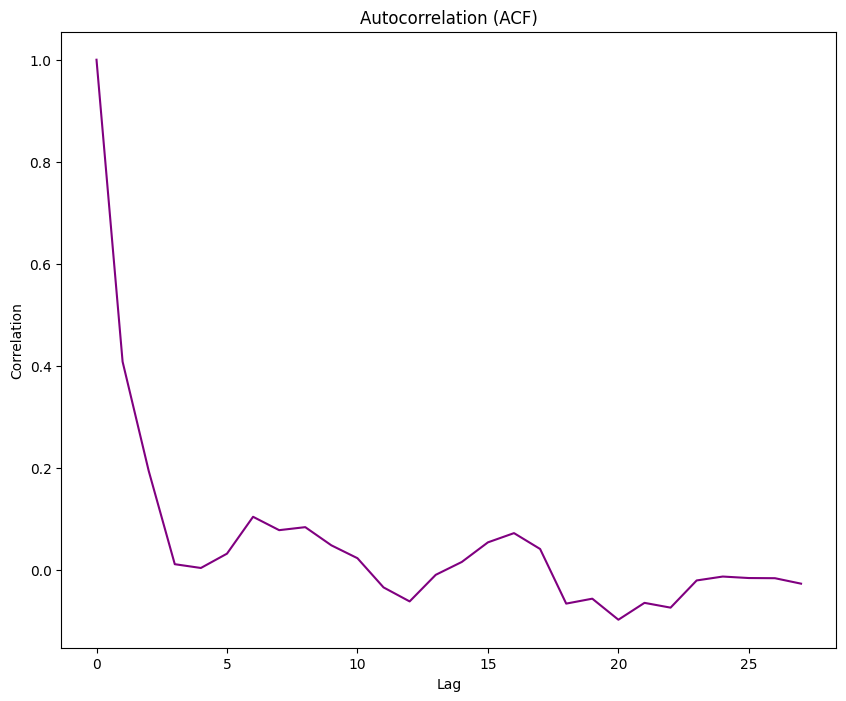

In [ ]:
#ACF Visualization
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(acf_df.ACF, 'purple')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Autocorrelation (ACF)')
plt.show()

In [ ]:
pacf = pacf((train['Revenue'].values))
pacf_df = pd.DataFrame([pacf]).T
pacf_df.columns = ['PACF']

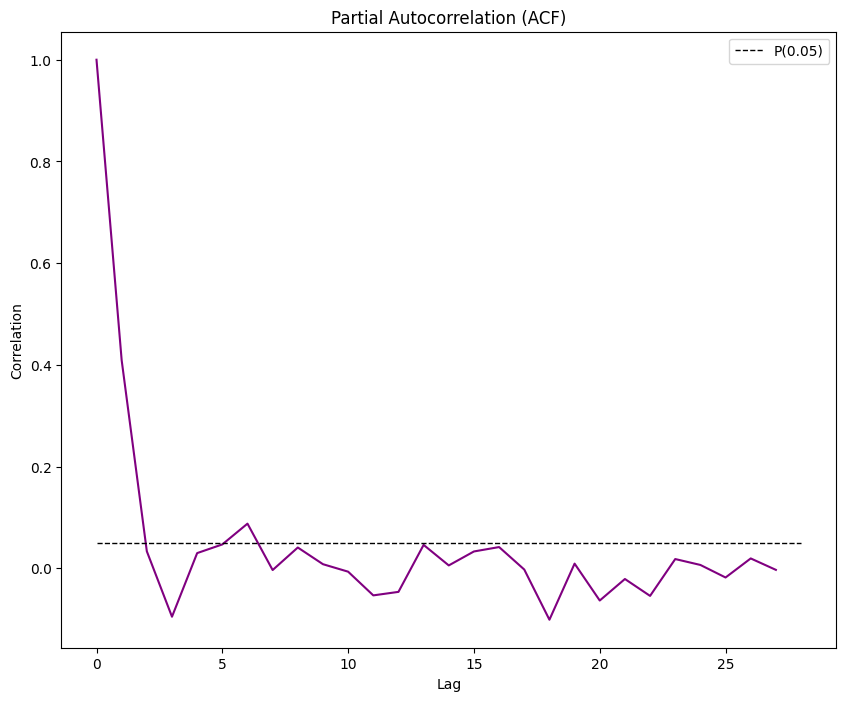

In [ ]:
#PACF Visualization
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(pacf_df.PACF, 'purple')
ax.hlines(y = 0.05, xmin = 0, xmax = len(pacf), lw = 1, linestyles = '--', color = 'black', label = 'P(0.05)')
ax.legend()
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Partial Autocorrelation (ACF)')
plt.show()

In [ ]:
df2.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d213_advanced_data_analytics/Task 1/data/task_1_df2_cleaned.csv')

In [ ]:
df_stationary.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d213_advanced_data_analytics/Task 1/data/task_1_df_stationary.csv')

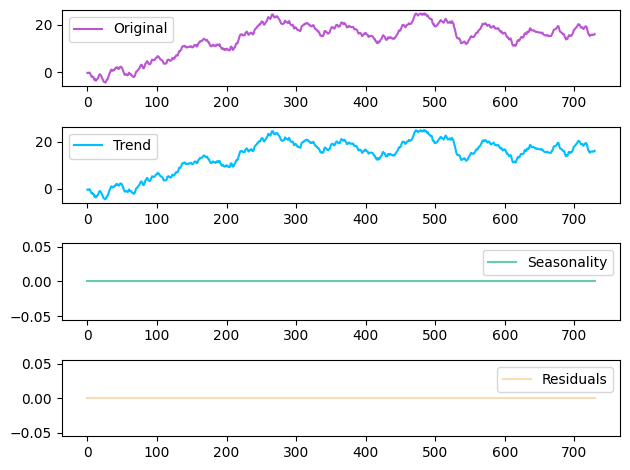

In [ ]:
#Use seasonal_decompose to plot decomposition values
decomposition = seasonal_decompose(df2['Revenue'].values, model = 'additive', period = 1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(df2['Revenue'].values, label = 'Original', color = 'mediumorchid')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'deepskyblue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', color = 'mediumaquamarine')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label = 'Residuals', color = 'wheat')
plt.legend(loc='best')
plt.tight_layout()

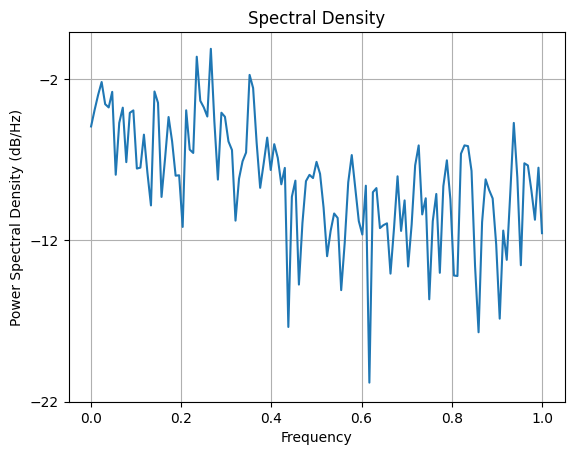

In [ ]:
plt.psd(df_stationary['Revenue'])
plt.title('Spectral Density')
plt.show()

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [ ]:
stepwise_fit = auto_arima(df2['Revenue'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=882.726, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.163, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=880.725, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=905.489, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1014.728, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=882.666, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=882.679, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=882.775, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.385, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.314, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.330, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=904.505, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.407, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.626 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.693
Date:                Tue, 20 Dec 2022   AIC                            879.385
Time:                        21:24:23   BIC                            888.568
Sample:                    01-02-2015   HQIC                           882.928
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.246      0.000       0.348       0.480
sigma2         0.1945      0.011     17.824      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = ARIMA(df2['Revenue'],order = (1,1,0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  730
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -437.693
Date:                Tue, 20 Dec 2022   AIC                            879.385
Time:                        21:24:24   BIC                            888.568
Sample:                    01-02-2015   HQIC                           882.928
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.246      0.000       0.348       0.480
sigma2         0.1945      0.011     17.824      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
print(df2.shape)
train = df2.iloc[:-30]
test = df2.iloc[-30:]
print(train.shape, test.shape)

(730, 1)
(700, 1) (30, 1)


In [ ]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start = start, end = end,typ = 'levels').rename('Predictions')
print(pred)

pred.index = df2.index[start:end + 1]

2016-12-02    18.311438
2016-12-03    18.025605
2016-12-04    18.497483
2016-12-05    18.933080
2016-12-06    19.212850
2016-12-07    19.502122
2016-12-08    20.365092
2016-12-09    20.402788
2016-12-10    19.923007
2016-12-11    19.631769
2016-12-12    18.583414
2016-12-13    18.753417
2016-12-14    19.050880
2016-12-15    18.576216
2016-12-16    17.973037
2016-12-17    19.162185
2016-12-18    19.006934
2016-12-19    19.539314
2016-12-20    19.324265
2016-12-21    18.170713
2016-12-22    16.845527
2016-12-23    15.666965
2016-12-24    15.909540
2016-12-25    14.941717
2016-12-26    15.878345
2016-12-27    15.780232
2016-12-28    15.708516
2016-12-29    15.925363
2016-12-30    15.644034
2016-12-31    15.870031
Freq: D, Name: Predictions, dtype: float64


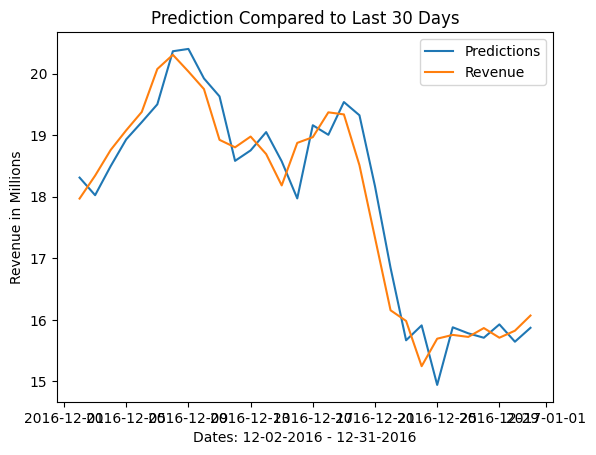

In [ ]:
pred.plot(legend = True)
test['Revenue'].plot(legend = True)
plt.xlabel('Dates: 12-02-2016 - 12-31-2016')
plt.ylabel('Revenue in Millions')
plt.title('Prediction Compared to Last 30 Days')
plt.show()

In [ ]:
test['Revenue'].mean()

17.923607082333337

In [ ]:
rmse = sqrt(mean_squared_error(pred, test['Revenue']))
rmse

0.44122430846080923

In [ ]:
model2 = ARIMA(df2['Revenue'], order = (1, 1, 0))
model2 = model2.fit()
df2.tail()

,Revenue
Date,
2016-12-27,15.722056
2016-12-28,15.865822
2016-12-29,15.708988
2016-12-30,15.822867
2016-12-31,16.069429


In [ ]:
index_future_dates = pd.date_range(start='2016-12-31', end = '2017-01-31')
print(index_future_dates)
pred = model.predict(start = len(train), end = len(train) + 31, typ ='levels').rename('30 Day Revenue Predictions')
pred.index = index_future_dates
pred

DatetimeIndex(['2016-12-31', '2017-01-01', '2017-01-02', '2017-01-03',
               '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-07',
               '2017-01-08', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
               '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19',
               '2017-01-20', '2017-01-21', '2017-01-22', '2017-01-23',
               '2017-01-24', '2017-01-25', '2017-01-26', '2017-01-27',
               '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31'],
              dtype='datetime64[ns]', freq='D')


2016-12-31    18.311438
2017-01-01    18.025605
2017-01-02    18.497483
2017-01-03    18.933080
2017-01-04    19.212850
2017-01-05    19.502122
2017-01-06    20.365092
2017-01-07    20.402788
2017-01-08    19.923007
2017-01-09    19.631769
2017-01-10    18.583414
2017-01-11    18.753417
2017-01-12    19.050880
2017-01-13    18.576216
2017-01-14    17.973037
2017-01-15    19.162185
2017-01-16    19.006934
2017-01-17    19.539314
2017-01-18    19.324265
2017-01-19    18.170713
2017-01-20    16.845527
2017-01-21    15.666965
2017-01-22    15.909540
2017-01-23    14.941717
2017-01-24    15.878345
2017-01-25    15.780232
2017-01-26    15.708516
2017-01-27    15.925363
2017-01-28    15.644034
2017-01-29    15.870031
2017-01-30    16.171544
2017-01-31    16.213835
Freq: D, Name: 30 Day Revenue Predictions, dtype: float64

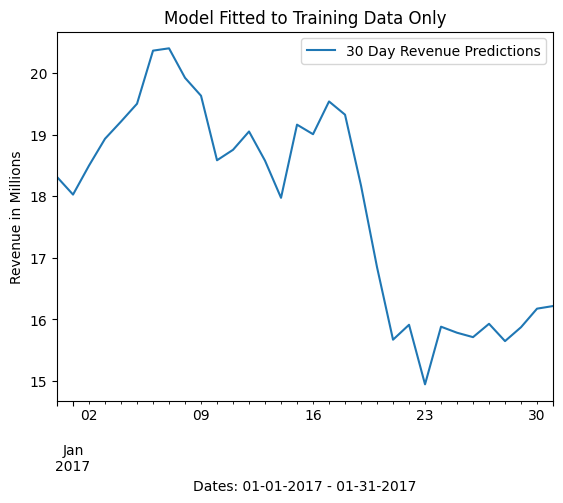

In [ ]:
pred.plot(legend = True)
plt.xlabel('Dates: 01-01-2017 - 01-31-2017')
plt.ylabel('Revenue in Millions')
plt.title('Model Fitted to Training Data Only')
plt.show()